In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utilities.utils import *

from src.plotting import Plotter
from src.gl_solver import GLSolver
from src.parameters_init import ParametersInit
from src.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1
# SEED = 1234

# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
Nx=8
Ny=8

Lx=50 
Ly=50

T_end = 1
dt = 0.005

N_ITERATIONS = int(T_end / dt)

In [4]:
A_norm, A_original, mem_rate, myu_original = compute_A_norm(
    Nx=Nx, 
    Ny=Ny, 
    input_to_defect_ratio=2*2, 
    mean=5.4, 
    std_deviation=0.8, 
    time_period=25, 
    Lx=Lx, 
    Ly=Ly, 
    dt=dt, 
    T_End=T_end, 
    parallel_runs=1, 
    input_scale=0.75, 
    mem_coef=1, 
    time_period_parameter=100, 
    _mean=5.4, 
    std_deviation_run_computation=1,
    input_myu=None
)

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 9618.09it/s]

Unique Myus count	 32
Max value of myu:	 98.85197228271444
Min value of myu:	 31.88124086517815
Unique values: [31.88124086517815, 37.359270372192285, 40.403393621893414, 43.05756207168323, 45.98773341353644, 49.24367785201386, 49.33108518051292, 50.32473718921848, 51.80089933009742, 56.206769050891836, 60.39270494769152, 60.628204306295025, 60.752503108835015, 60.9228661289371, 61.43770738474606, 61.48702528832784, 64.88013229482216, 65.00817838529062, 66.26218339532609, 68.17196198382413, 72.46314655157944, 73.32744083352007, 74.15451752168602, 74.76602992793298, 77.67698489736703, 79.04849442903783, 79.56678379997396, 79.86160873696112, 82.70099631570164, 86.0218134857251, 86.88102652417446, 98.85197228271444]
Counts:		 [400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400]
A.shape=(1, 200, 8, 8),
Myu.shape=(1, 200, 8, 8),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


In [5]:
def output_plot(data, mem_rat, save_fig=False, file_name="A_in_norm_80%04d.png"):
    fig = plt.figure(1, figsize=(6.5, 6.5))
    for index in tqdm(range(mem_rat)):
        if index % 2 == 0:
            plt.clf()
            plt.imshow(data[index, :, :], origin='lower', vmax=0.9*np.max(data))
            plt.colorbar()
            if save_fig:
                filename = file_name % (index/2)
                plt.savefig(filename)

100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 69.53it/s]


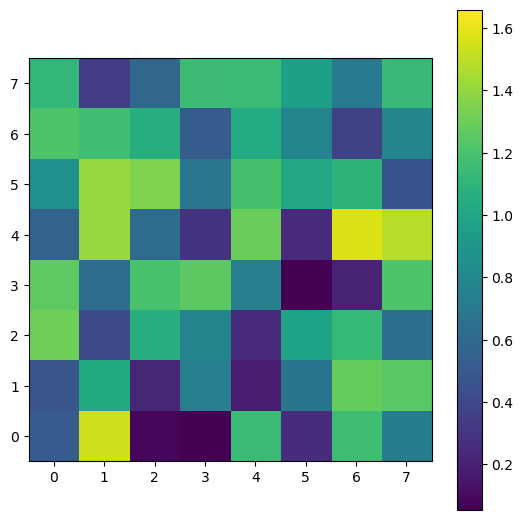

In [6]:
output_plot(A_norm, mem_rate)

GETTING HANDS DIRTY WITH THE NEURAL NETWORKS

In [7]:
snn_layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1]

x = np.linspace(0, Lx, Nx).flatten()[:, None]
y = np.linspace(0, Ly, Ny).flatten()[:, None]
t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]

Exact = A_original.squeeze(0)

X, T, Y = np.meshgrid(x, t, y)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()
u_star = np.hstack([u_star.real[:, None],u_star.imag[:, None]])

In [8]:
X_star.shape, u_star.shape

((12800, 3), (12800, 2))

$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [9]:
class LOSS:
  def __init__(self, x, y, t, verbose = 0):
      self.msef = nn.MSELoss()
      self.MSE = []
      self.F = []
      self.FMSE = []
      self.verbose = verbose
      self.x = x
      self.y = y
      self.t = t

  def load(self,y_pred,y_real):
      self.y_pred = y_pred
      self.y_real = y_real

    
  def plot(self):
    fig, [upper,lower] = plt.subplots(nrows=2)
    upper.plot(self.MSE)
    upper.legend("MSE")
    upper.set_title("MSE")
    upper.set_yscale('log')
    lower.plot(self.FMSE)
    lower.legend("FMSE")
    lower.set_title("FMSE")
    lower.set_yscale('log')
    plt.show()

  def mse(self):
      loss = self.msef(self.y_pred,self.y_real)
      if(self.verbose):
        print(f"MSELOSS: {loss}")
      self.MSE.append(loss.cpu().detach().numpy())
      return loss

  def fmse(self, myu):
    f_loss = torch.mean(torch.abs(self.net_f(myu)) ** 2)
    self.FMSE.append(f_loss.cpu().detach().numpy())
    return f_loss

  def __radd__(self, other):
    if other == 0:
        return self
    else:
        return self.__add__(other)  
  def __add__(self, L):
    l = LOSS(self.x,self.y,self.t, verbose = self.verbose)
    if "y_pred" in dir(self):
        l.load(self.y_pred, self.y_real)
    if "y_pred" in dir(L):
        l.load(L.y_pred, L.y_real)
    l.MSE = self.MSE + L.MSE
    l.FMSE = self.FMSE + L.FMSE
    l.F = self.F + L.F
    return l

  def net_f(self, myu, verbose = 0):
        torch.autograd.set_detect_anomaly(True)
        x,y,t = self.x, self.y, self.t

        ru = self.y_pred[:,0]
        iu = self.y_pred[:,1]

        (ru_t, ru_x, ru_y) = torch.autograd.grad(ru, (t, x, y), grad_outputs=torch.ones_like(ru), create_graph=True, retain_graph=True)
        (iu_t, iu_x, iu_y) = torch.autograd.grad(iu, (t, x, y), grad_outputs=torch.ones_like(iu), create_graph=True, retain_graph=True)

        (ru_xx,) = torch.autograd.grad(ru_x, (x), grad_outputs=torch.ones_like(ru_x), create_graph=True)
        (iu_xx,) = torch.autograd.grad(iu_x, (x), grad_outputs=torch.ones_like(iu_x), create_graph=True)

        (ru_yy,) = torch.autograd.grad(ru_y, (y), grad_outputs=torch.ones_like(ru_y), create_graph=True)
        (iu_yy,) = torch.autograd.grad(iu_y, (y), grad_outputs=torch.ones_like(iu_y), create_graph=True)

        u =( ru + iu * 1j).view(200, 4, 4)
        u_t = (ru_t + iu_t * 1j).view(200, 4, 4)
        u_xx =( ru_xx + iu_xx *1j).view(200, 4, 4)
        u_yy = (ru_yy + iu_yy *1j).view(200, 4, 4)

        if(verbose):
            print('u_t:',u_t)
            print('u:',u)
            print('u_xx:',u_xx)
            print('u_yy:',u_yy)
            
        f = u_t - myu*u - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u
        free_memory(u, u_t, u_xx, u_yy)

        return f
def free_memory(*variables):
    del variables
    torch.cuda.empty_cache()

In [10]:
class GALAXYNET(nn.Module):
    def __init__(self, layers_list, activation_function_list = None, linm = None):
        super(GALAXYNET, self).__init__()
        self._depth = len(layers_list) - 1
        
        if activation_function_list is None:
            activation_function_list = [F.softplus for _ in range(self._depth - 1)]
            
        if linm is None:
            linm =  np.tril(np.ones(self._depth + 1, dtype = int))
        lin = linm@layers_list
        
        self._activation_function_list = activation_function_list
        
        self._Wtmx = nn.Sequential(*[torch.nn.Linear(lin[i], layers_list[i+1], dtype = torch.float64) for i in range(self._depth)])
        self._linm = linm
        
        self.optimizer = torch.optim.Adam( params = self._Wtmx.parameters(), lr=0.01 )    
        
    
    def forward(self, x):
        layers = [x,self._Wtmx[0](x)]
        for i in range(1, self._depth):
            layers[i] = self._activation_function_list[i-1](layers[i])
            ind = self._linm[i]
            inpind = np.where(ind)[0]
            inp = torch.concat([layers[i] for i in inpind], dim=1)
            layers.append(self._Wtmx[i](inp))
        return layers[-1]        

    def predict(self, x):
        self._Wtmx.eval()
        if type(x) is not torch.Tensor:
            x = torch.tensor(x, dtype = torch.float64).to(device)
        y =  self.forward(x).cpu().detach().numpy()
        return y[:,0] + y[:,1]*1j    

    def lossf(self, y, y_pred):
        mseloss = torch.sum((y_pred - y)**2,dim=1)
        return torch.sum(torch.sqrt(mseloss))
    
    def fastmsetrain(self, x, y, epochs=100):
        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        
        self.optimizer.zero_grad()
        L = []
        
        for _ in tqdm(range(epochs)):
            y_pred = self.forward(x)
            loss = self.lossf(y,y_pred)
            L.append(loss.cpu().detach().numpy())
            loss.backward()   
            self.optimizer.step()
            self._Wtmx.zero_grad()       

        return L       

    def fastmsebatchtrain(self, x, y, epochs=100, batch_size = 64):
        from torch.utils.data import DataLoader

        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        dataloader = DataLoader(dataset = torch.hstack((x,y)), batch_size=batch_size, shuffle=True)
        
        self.optimizer.zero_grad()
        L = []
        
        import math
        batchiter = (epochs * batch_size)  // x.size()[0]
        epochs =  batchiter * math.ceil(x.size()[0] / batch_size)
        
        pbar = tqdm(total=epochs)
        try:
            for _ in range(batchiter):
                for i, tmp in enumerate(dataloader):
                    (tmpx, tmpy, tmpt, tmpu_real, tmpu_img) = tmp.T
                    X = torch.stack((tmpx,tmpy,tmpt)).T
                    U = torch.stack((tmpu_real, tmpu_img)).T

                    y_pred = self.forward(X)
                    loss = self.lossf(y_pred,U)
                    L.append(loss.cpu().detach().numpy())
                    loss.backward()
                    self.optimizer.step()
                    self._Wtmx.zero_grad()
                    # Update the progress bar
                    pbar.update(1)
        except:
            pass
        finally:

            # Close the progress bar
            pbar.close()          
        return L       

In [11]:
import torch
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(False)
torch.manual_seed(0)
net = GALAXYNET([3,8,32,64,32,8,2]).to(device)
L1 = net.fastmsebatchtrain(x = X_star, y = u_star, epochs = 100000)

100%|█████████████████████████████████| 100000/100000 [01:36<00:00, 1038.76it/s]


In [12]:
net.optimizer.param_groups[0]['lr'] = 0.003
L2 = net.fastmsebatchtrain(x = X_star, y = u_star, epochs = 100000)

100%|██████████████████████████████████| 100000/100000 [01:40<00:00, 995.70it/s]


In [21]:
net.optimizer.param_groups[0]['lr'] = 0.001
L3 = net.fastmsebatchtrain(x = X_star, y = u_star, epochs = 100000)

100%|██████████████████████████████████| 100000/100000 [01:43<00:00, 961.88it/s]


In [22]:
net.optimizer.param_groups[0]['lr'] = 0
L4 = net.fastmsebatchtrain(x = X_star, y = u_star, epochs = 1000)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 948.33it/s]


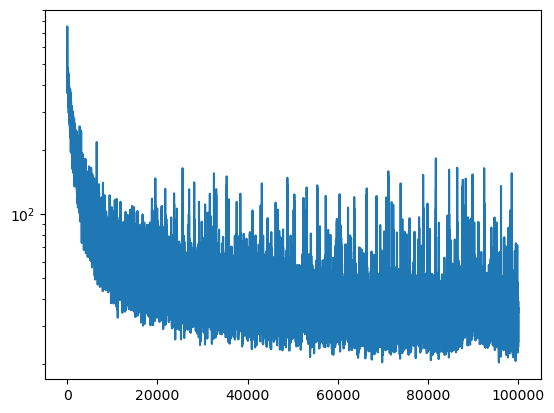

In [23]:
plt.plot(L1)
plt.yscale('log')

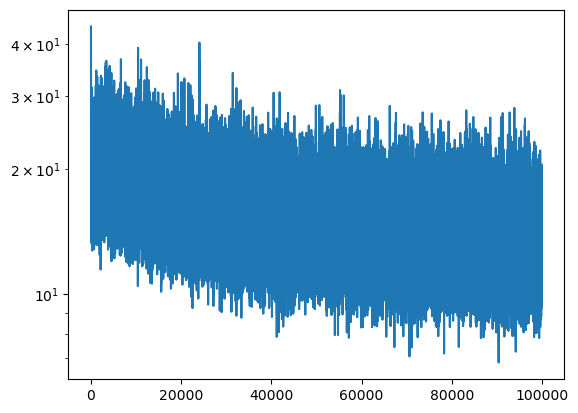

In [24]:
plt.plot(L2)
plt.yscale('log')

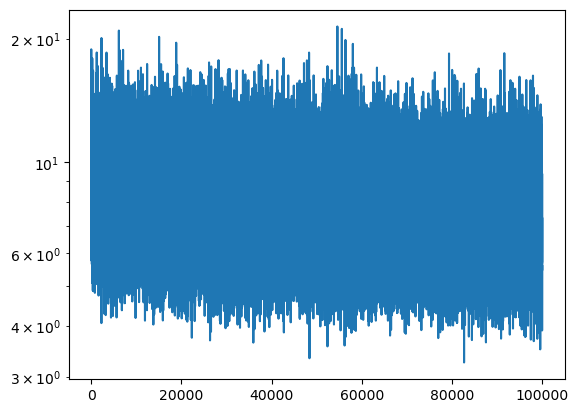

In [43]:
plt.plot(L3)
plt.yscale('log')

In [33]:
np.average(np.abs(net.predict(X_star)- A_original.reshape(-1))**2)

0.045924767368959146

100%|█████████████████████████████████████████| 200/200 [00:10<00:00, 19.52it/s]


GIF successfully saved at galaxynet_test.gif


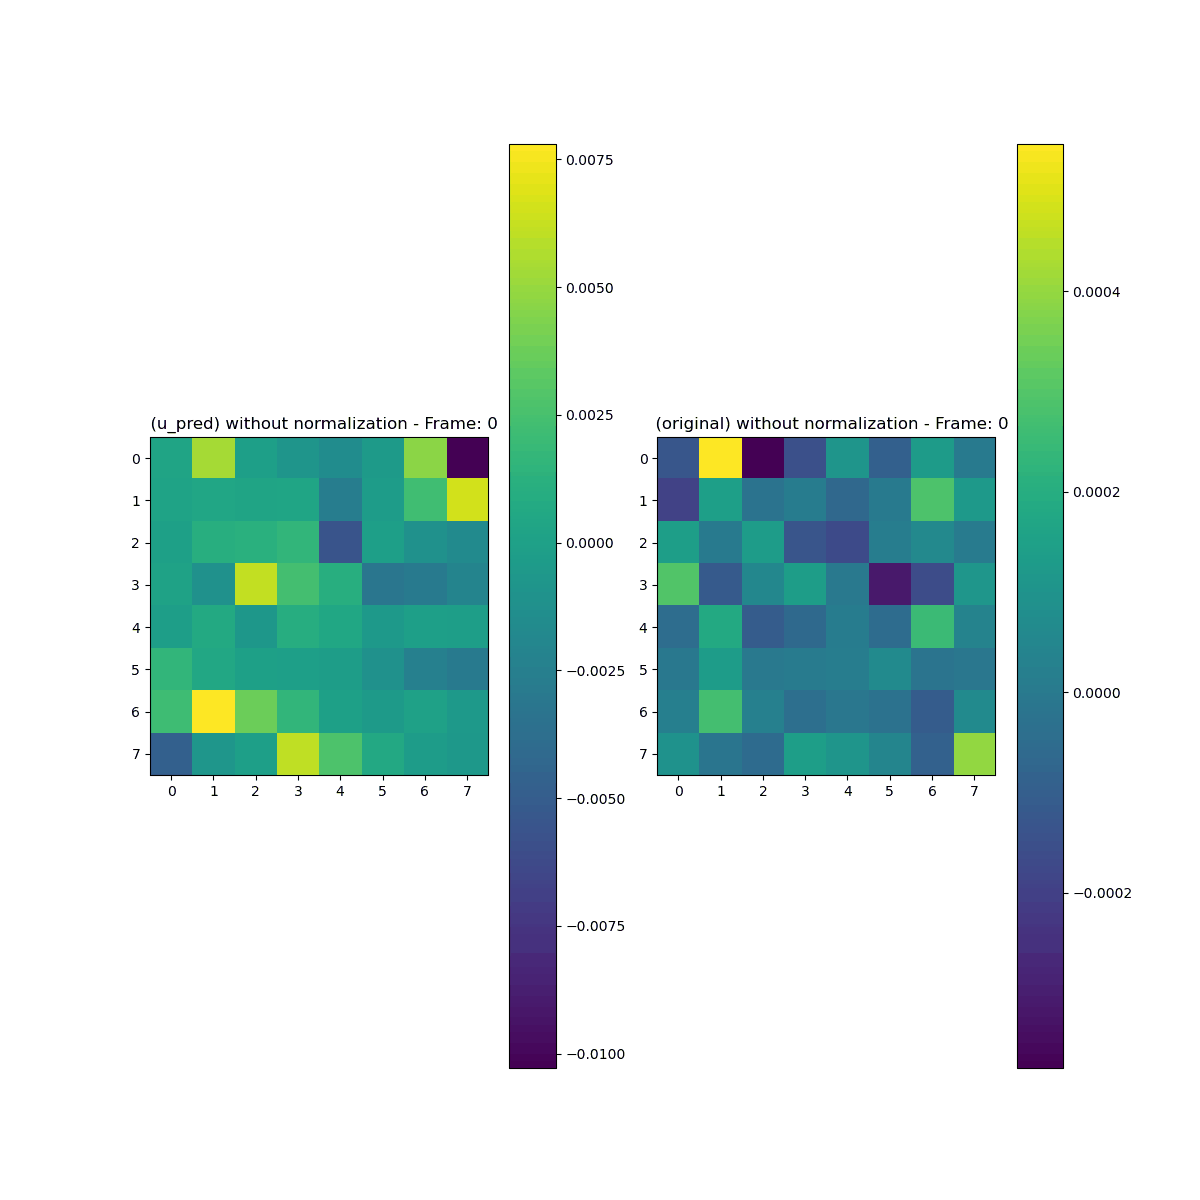

In [37]:
path="galaxynet_test"
create_gifs(
    memory_rate=mem_rate,
    u_pred=net.predict(X_star),
    original=A_original,
    save=True,
    path_for_gif=path+".gif",
    duration=500,
    title=" "
)
Image(filename=path+".gif")

In [38]:
gif = imageio.mimread(path+".gif", memtest=False)
nums = len(gif)
print("Total {} frames in the gif {}!".format(nums, path+".gif"))

Total 100 frames in the gif galaxynet_test.gif!


In [39]:
# Convert form BGR to RGB
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in gif]

# Save frames to video
out = cv2.VideoWriter(path+'.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 2, (imgs[0].shape[1], imgs[0].shape[0]))

for img in imgs:
    out.write(img)

out.release()

[ WARN:0@486.378] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2180) open OpenCV | GStreamer warning: cannot link elements
